In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastparquet
import dask.dataframe as dd
from utils import pipe_newb,pipe_broken,pipe_rental
import koreanize_matplotlib
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from scipy.stats import shapiro
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

c:\Users\chane\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### 데이터

In [2]:
df_rental = dd.read_parquet('rental.parquet',engine='pyarrow')
df_rental = df_rental.compute()
df_rental = pipe_rental(df_rental)

In [3]:
df_newb = pd.read_csv('Data\원본\신규가입자합산값.csv')
df_newb = pipe_newb(df_newb)

In [4]:
df_broken = pd.read_csv('Data\원본\고장\df_broken.csv')
df_broken = pipe_broken(df_broken)

## 1. 시계열 그래프 추세 시각화 -> 2022년과 2023년 패턴이 다르다는 것을 발견

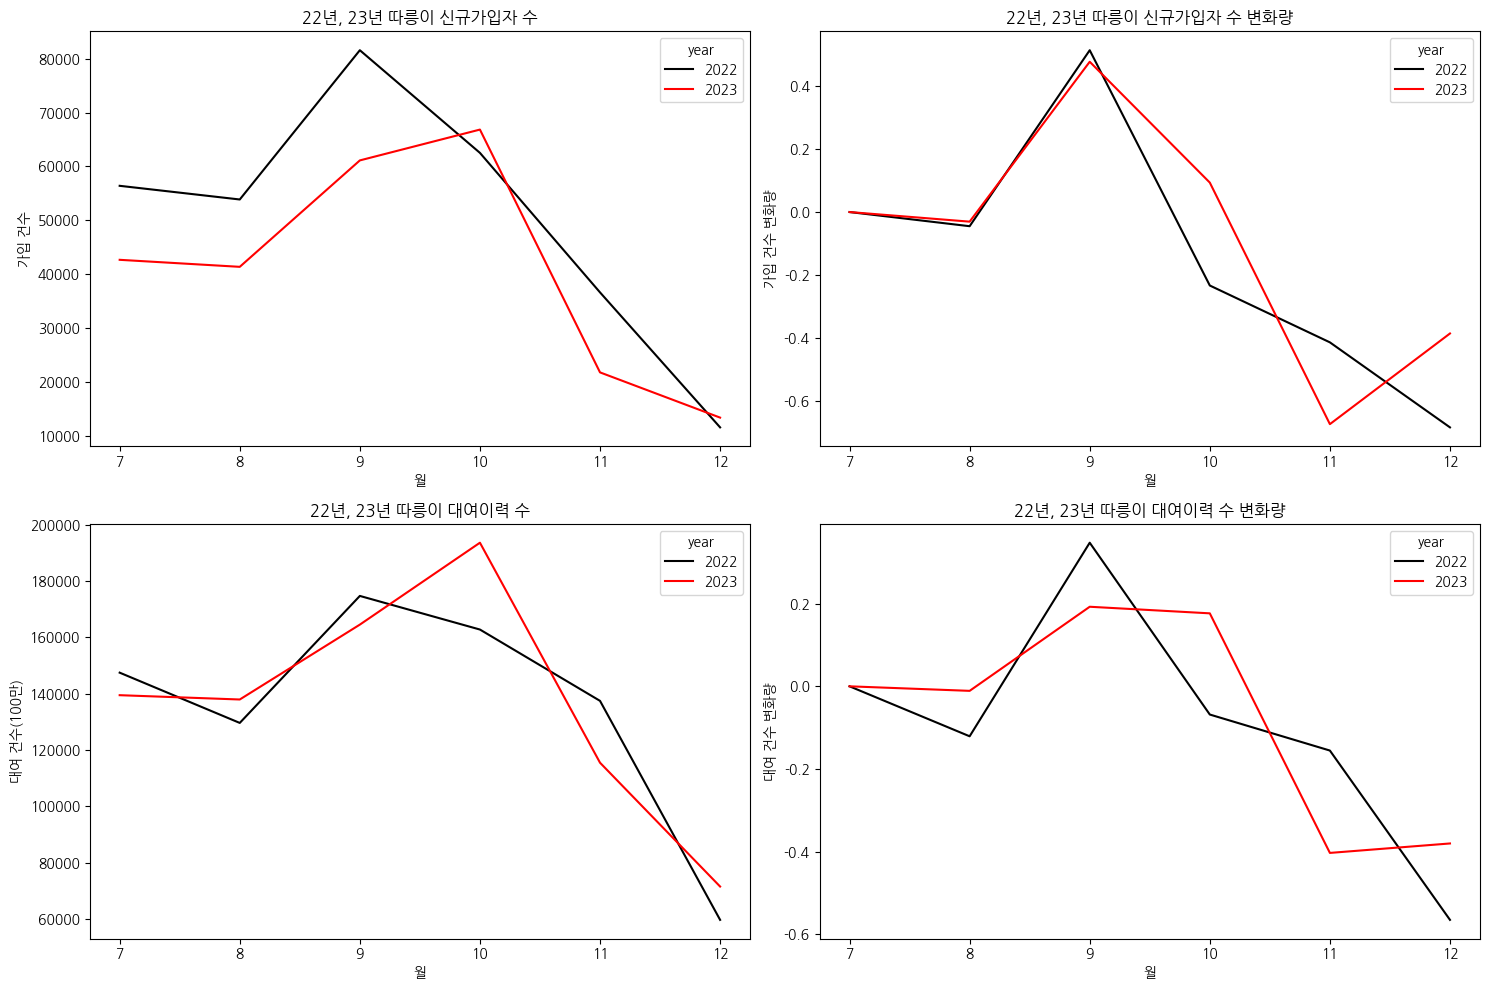

In [5]:
# 신규가입자 건수 groupby
df_newb_groupby = (
    df_newb
    .groupby([df_newb['가입일시'].dt.year.rename('year'), df_newb['가입일시'].dt.month.rename('month')])
    .agg({'가입건수':'sum'})
    .reset_index()    
)
# 신규가입자 건수 2022년도 변화량
df_newb22_groupby = (
    df_newb_groupby
    .loc[df_newb_groupby['year'] == 2022]
    .assign(가입건수_변화량= lambda x: x['가입건수'].pct_change().fillna(0))
) 
# 신규가입자 건수 2023년도 변화량
df_newb23_groupby = (
    df_newb_groupby
    .loc[df_newb_groupby['year'] == 2023]
    .assign(가입건수_변화량= lambda x: x['가입건수'].pct_change().fillna(0))
) 
# 신규가입자 건수 및 변화량 2022년도 2023년도 병합
df_newb_groupby = pd.concat([df_newb22_groupby, df_newb23_groupby])


# 대여이력 건수 groupby
df_rental_groupby = (
    df_rental
    .groupby([df_rental['대여일시'].dt.year.rename('year'), df_rental['대여일시'].dt.month.rename('month')])
    .agg({'자전거번호':'size'})
    .reset_index()
) 
# 대여이력 건수 2022년도 변화량
df_rental22_groupby = (
    df_rental_groupby
    .loc[df_rental_groupby['year'] == 2022]
    .assign(대여건수_변화량= lambda x: x['자전거번호'].pct_change().fillna(0))
) 
# 대여이력 건수 2023년도 변화량
df_rental23_groupby = (
    df_rental_groupby
    .loc[df_rental_groupby['year'] == 2023]
    .assign(대여건수_변화량= lambda x: x['자전거번호'].pct_change().fillna(0))
) 
# 대여이력 건수 및 변화량 2022년도 2023년도 병합
df_rental_groupby = pd.concat([df_rental22_groupby, df_rental23_groupby])

# 신규가입자 정보 및 대여이력정보 시각화
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 신규가입자 건수 시각화
df_newb_groupby.pivot(index='month', columns='year', values='가입건수').plot(kind='line', color=['black', 'red'], ax=axs[0, 0])
axs[0, 0].set_title('22년, 23년 따릉이 신규가입자 수')
axs[0, 0].set_xlabel('월')
axs[0, 0].set_ylabel('가입 건수')

# 신규가입자 변화량 시각화
df_newb_groupby.pivot(index='month', columns='year', values='가입건수_변화량').plot(kind='line', color=['black', 'red'], ax=axs[0, 1])
axs[0, 1].set_title('22년, 23년 따릉이 신규가입자 수 변화량')
axs[0, 1].set_xlabel('월')
axs[0, 1].set_ylabel('가입 건수 변화량')

# 대여이력 건수 시각화
df_rental_groupby.pivot(index='month', columns='year', values='자전거번호').plot(kind='line', color=['black', 'red'], ax=axs[1, 0])
axs[1, 0].set_title('22년, 23년 따릉이 대여이력 수')
axs[1, 0].set_xlabel('월')
axs[1, 0].set_ylabel('대여 건수(100만)')

# 대여이력 변화량 시각화
df_rental_groupby.pivot(index='month', columns='year', values='대여건수_변화량').plot(kind='line', color=['black', 'red'],ax=axs[1, 1])
axs[1, 1].set_title('22년, 23년 따릉이 대여이력 수 변화량')
axs[1, 1].set_xlabel('월')
axs[1, 1].set_ylabel('대여 건수 변화량')

plt.tight_layout()
plt.show()

## 신규가입자,대여건수에 대한 고장건수의 상관관계

1. 신규가입자의 수가 늘어난다면 고장횟수가 늘어날까?

2. 대여건수가 늘어나면 고장횟수가 늘어날까?

In [6]:
rental_date = df_rental.groupby(pd.to_datetime(df_rental['대여일시'].dt.date.rename('date')))['자전거번호'].count().reset_index()

In [7]:
df_newb.drop('month',axis=1,inplace=True)

In [8]:
df_newb_2022 = df_newb[df_newb['가입일시'].dt.year == 2022]
df_newb_2023 = df_newb[df_newb['가입일시'].dt.year == 2023]
df_newb_2022 = df_newb_2022.rename(columns={'가입일시': '일시'})
df_newb_2023 = df_newb_2023.rename(columns={'가입일시': '일시'})

In [9]:
df_broken_count = df_broken.groupby(df_broken['등록일시'].dt.to_period('M')).size().reset_index()
df_broken_count = df_broken_count.rename(columns={0: '고장건수'})

In [10]:
df_broken_22 = df_broken_count[df_broken_count['등록일시'].dt.year == 2022]
df_broken_23 = df_broken_count[df_broken_count['등록일시'].dt.year == 2023]
df_broken_22 = df_broken_22.rename(columns={'등록일시': '일시'})
df_broken_23 = df_broken_23.rename(columns={'등록일시': '일시'})

In [11]:
merged_2022 = pd.merge(df_newb_2022, df_broken_22, on=['일시'], how='left').fillna(0)
merged_2023 = pd.merge(df_newb_2023, df_broken_23, on=['일시'], how='left').fillna(0)

In [12]:
corr_2022, p_value_2022 = stats.pearsonr(merged_2022['가입건수'], merged_2022['고장건수'])
corr_2023, p_value_2023 = stats.pearsonr(merged_2023['가입건수'], merged_2023['고장건수'])
print("2022년 가입건수-고장건수 상관계수:", corr_2022)
print("2022년 가입건수-고장건수 p-value:", p_value_2022)
print("2023년 가입건수-고장건수 상관계수:", corr_2023)
print("2023년 가입건수-고장건수 p-value:", p_value_2023)

2022년 가입건수-고장건수 상관계수: 0.9829694114440466
2022년 가입건수-고장건수 p-value: 0.00043259163583061696
2023년 가입건수-고장건수 상관계수: 0.8076890197680174
2023년 가입건수-고장건수 p-value: 0.05191910184662714


전체 건수 비교 이외에 전월과 증가폭을 계산해서 진행

In [13]:
def calculate_monthly_increase(df):
    df['가입건수_증가폭'] = df['가입건수'].diff().fillna(0)
    df['고장횟수_증가폭'] = df['고장건수'].diff().fillna(0)
    return df

In [14]:
monthly_diff_2022 = calculate_monthly_increase(merged_2022)
monthly_diff_2023 = calculate_monthly_increase(merged_2023)

In [15]:
corr_2022, p_value_2022 = stats.pearsonr(monthly_diff_2022['가입건수_증가폭'], monthly_diff_2022['고장횟수_증가폭'])
corr_2023, p_value_2023 = stats.pearsonr(monthly_diff_2023['가입건수_증가폭'], monthly_diff_2023['고장횟수_증가폭'])
print("2022년 가입건수_증가폭-고장횟수 증가폭 상관계수:", corr_2022)
print("2022년 가입건수_증가폭-고장횟수 증가폭 p-value:", p_value_2022)
print("2023년 가입건수_증가폭-고장횟수 증가폭 상관계수:", corr_2023)
print("2023년 가입건수_증가폭-고장횟수 증가폭 p-value:", p_value_2023)

2022년 가입건수_증가폭-고장횟수 증가폭 상관계수: 0.9790974346514256
2022년 가입건수_증가폭-고장횟수 증가폭 p-value: 0.000650809511665944
2023년 가입건수_증가폭-고장횟수 증가폭 상관계수: 0.6259157766297325
2023년 가입건수_증가폭-고장횟수 증가폭 p-value: 0.18373402203980005


In [16]:
df_rental22_groupby['일시'] = pd.to_datetime(df_rental22_groupby[['year', 'month']].assign(day=1)).dt.to_period('M')
df_rental23_groupby['일시'] = pd.to_datetime(df_rental23_groupby[['year', 'month']].assign(day=1)).dt.to_period('M')

In [17]:
df_rental22_groupby.drop(['대여건수_변화량','month','year'],axis=1,inplace=True)
df_rental23_groupby.drop(['대여건수_변화량','month','year'],axis=1,inplace=True)

In [18]:
df_rental22_groupby = df_rental22_groupby.rename(columns={'자전거번호': '대여건수'})
df_rental23_groupby = df_rental23_groupby.rename(columns={'자전거번호': '대여건수'})
df_rental22_groupby.head()

,대여건수,일시
0,147510,2022-07
1,129666,2022-08
2,174749,2022-09
3,162814,2022-10
4,137498,2022-11


In [19]:
merged_2022 = pd.merge(df_rental22_groupby, df_broken_22, on=['일시'], how='left').fillna(0)
merged_2023 = pd.merge(df_rental23_groupby, df_broken_23, on=['일시'], how='left').fillna(0)

In [20]:
corr_2022, p_value_2022 = stats.pearsonr(merged_2022['대여건수'], merged_2022['고장건수'])
corr_2023, p_value_2023 = stats.pearsonr(merged_2023['대여건수'], merged_2023['고장건수'])
print("2022년 대여건수-고장건수 상관계수:", corr_2022)
print("2022년 대여건수-고장건수 p-value:", p_value_2022)
print("2023년 대여건수-고장건수 상관계수:", corr_2023)
print("2023년 대여건수-고장건수 p-value:", p_value_2023)

2022년 대여건수-고장건수 상관계수: 0.9720215288358554
2022년 대여건수-고장건수 p-value: 0.0011632415714736529
2023년 대여건수-고장건수 상관계수: 0.8902266816643759
2023년 대여건수-고장건수 p-value: 0.017413877927198625


앞선 방식과 동일하게 전월의 차이를 계산해서 진행

In [21]:
def calculate_monthly_increase(df):
    df['대여건수_증가폭'] = df['대여건수'].diff().fillna(0)
    df['고장횟수_증가폭'] = df['고장건수'].diff().fillna(0)
    return df

In [22]:
monthly_diff_2022 = calculate_monthly_increase(merged_2022)
monthly_diff_2023 = calculate_monthly_increase(merged_2023)

In [23]:
corr_2022, p_value_2022 = stats.pearsonr(monthly_diff_2022['대여건수_증가폭'], monthly_diff_2022['고장횟수_증가폭'])
corr_2023, p_value_2023 = stats.pearsonr(monthly_diff_2023['대여건수_증가폭'], monthly_diff_2023['고장횟수_증가폭'])
print("2022년 대여건수_증가폭-고장횟수 증가폭 상관계수:", corr_2022)
print("2022년 대여건수_증가폭-고장횟수 증가폭 p-value:", p_value_2022)
print("2023년 대여건수_증가폭-고장횟수 증가폭 상관계수:", corr_2023)
print("2023년 대여건수_증가폭-고장횟수 증가폭 p-value:", p_value_2023)

2022년 대여건수_증가폭-고장횟수 증가폭 상관계수: 0.93935671447273
2022년 대여건수_증가폭-고장횟수 증가폭 p-value: 0.005404901000900471
2023년 대여건수_증가폭-고장횟수 증가폭 상관계수: 0.7867739162499159
2023년 대여건수_증가폭-고장횟수 증가폭 p-value: 0.06335084355995355


신규가입자와 대여이력의 경우, 대중교통 요금 인상 시기 한달 후인 각 9월 11월에 대해 지난 년도와 달리 상승폭 보이는 그래프의 형태가 보였고 이는 대중 교통 요금 인상이 영향을 준다고 판단 -> 더 자세한 추론 통계를 진행

## 2. 두 연도간의 비교 

### 2-1. t-test : 연간 평균 가입자 수를 비교 (정규성 가정이 충족되지 않을 경우, Mann-Whitney U test와 같은 비모수 검정)

Shapiro-Wilk test : 정규성 검사

귀무 가설 H0: '데이터가 정규분포를 따른다.'

대립 가설 H1: '데이터가 정규분포를 따르지 않는다.'

In [24]:
#정규성
print(stats.shapiro(df_rental22_groupby['대여건수']))
print(stats.shapiro(df_rental23_groupby['대여건수']))

ShapiroResult(statistic=0.8624640974880204, pvalue=0.19778142411056415)
ShapiroResult(statistic=0.9791561257326477, pvalue=0.9472868667650852)


In [25]:
#등분산성 검사
levene_stat, levene_p = stats.levene(df_rental22_groupby['대여건수'], df_rental23_groupby['대여건수'])
print("2022-2023년 대여건수 등분산성 검정 (Levene's test):", levene_stat)
print("2022-2023년 대여건수 p-value (Levene's test):", levene_p)

2022-2023년 대여건수 등분산성 검정 (Levene's test): 0.021452760210808025
2022-2023년 대여건수 p-value (Levene's test): 0.8864628812327375


In [26]:
#t-test
t_stat_use, p_value_use = stats.ttest_ind(df_rental22_groupby['대여건수'],df_rental23_groupby['대여건수'])
print("2022-2023년 대여건수 t-tset:", t_stat_use)
print("2022-2023년 대여건수 p-value:", p_value_use)

2022-2023년 대여건수 t-tset: -0.07599845039857428
2022-2023년 대여건수 p-value: 0.9409192873258406


Shapiro-Wilk의 p-value값이 둘 다 0.05를 넘기 때문에 데이터가 정규 분포를 따른다라고 판단. 

T-test 진행

T-test의 p-value가 0.94로 2022년도와 2023년도의 대여건수는 통계적으로 유의미한 차이가 없다.

### 2-2. 반복측정 anova : 월 별 비교 

In [27]:
#정규성 가정
data = df_rental.groupby([df_rental['대여일시'].dt.year, df_rental['대여일시'].dt.month])['자전거번호'].count()
data.index.names=['연도', '월']
data = pd.DataFrame(data)
data.reset_index(inplace = True)
data['변화량'] = data.groupby('연도')['자전거번호'].pct_change()

stat, p_value = shapiro(data['변화량'].fillna(0))
print(f"변화량 Shapiro-Wilk Test P-value: {p_value}")

변화량 Shapiro-Wilk Test P-value: 0.8394595776989427


월별 대여건수에 대한 변화량을 기반으로 정규성 검사를 진행

p-value가 0.05을 넘기 때문에 정규분포를 따른다라고 판단.

In [28]:
data['변화량'] = data['변화량'].fillna(0)

# AnovaRM을 사용하여 반복 측정 ANOVA 수행
anova = AnovaRM(data=data, depvar='변화량', subject='월', within=['연도'])

anova_results = anova.fit()

# 결과 출력
print(anova_results)

             Anova
   F Value Num DF Den DF Pr > F
-------------------------------
연도  0.0830 1.0000 5.0000 0.7848



연도에 따라 대여건수의 변화량에 차이가 있는지 알아보기 위해 AnovaRM사용

F-Value : 0.083

P-Value(Pr>F) : 0.78

**22년도와 23년도 월별 대여 변화량에 차이가 없다라는 결론**

In [29]:
#정규성 가정
data = df_rental.groupby([df_rental['대여일시'].dt.year, df_rental['대여일시'].dt.month])['자전거번호'].count()
data.index.names=['연도', '월']
data = pd.DataFrame(data)
data.reset_index(inplace = True)

stat, p_value = shapiro(data['자전거번호'].fillna(0))
print(f"변화량 Shapiro-Wilk Test P-value: {p_value}")

변화량 Shapiro-Wilk Test P-value: 0.3584383814875804


In [59]:
data['변화량'] = data['변화량'].fillna(0)

# AnovaRM을 사용하여 반복 측정 ANOVA 수행
anova = AnovaRM(data=data, depvar='자전거번호', subject='월', within=['연도'])

anova_results = anova.fit()

# 결과 출력
print(anova_results)

             Anova
   F Value Num DF Den DF Pr > F
-------------------------------
연도  0.0546 1.0000 5.0000 0.8245



연도에 따라 대여건수 차이를 알아보기 위한 AnovaRM

F-Value : 0.0546 

P-Value(Pr>F) : 0.8245

**22년도와 23년도 월별 대여 변화량에 차이가 없다라는 결론**

## 3. 요금 인상 전 후의 비교 

### 3-1. t-test : 8월 인상 전 후, 10월 인상 전 후 

In [60]:
df_rental['year'] = df_rental['대여일시'].dt.year
df_rental['month'] = df_rental['대여일시'].dt.month
df_rental['day'] = df_rental['대여일시'].dt.day
df_rental['대여건수'] = df_rental.groupby(['year', 'month', 'day'])['대여일시'].transform('count')
df_increase = df_rental[['year', 'month', 'day', '대여건수']]
df_increase=df_increase.groupby(['year','month', 'day'])['대여건수'].sum().reset_index()
data_jul_to_aug = df_increase[(df_increase['month'] >= 7) & (df_increase['month'] <= 8)]
data_sept_to_oct = df_increase[(df_increase['month'] >= 9) & (df_increase['month'] <= 10)]
data_nov_to_dec = df_increase[(df_increase['month'] >= 11) & (df_increase['month'] <= 12)]
group_before = data_jul_to_aug[data_jul_to_aug['year'] == 2023]
group_first = data_sept_to_oct[data_sept_to_oct['year'] == 2023]
group_second = data_nov_to_dec[data_nov_to_dec['year'] == 2023]

In [61]:
#정규성 확인
shapiro_jul_aug = stats.shapiro(group_before['대여건수'])
shapiro_sept_oct = stats.shapiro(group_first['대여건수'])
shapiro_nov_dec = stats.shapiro(group_second['대여건수'])
print(shapiro_jul_aug)
print(shapiro_sept_oct)
print(shapiro_nov_dec)

ShapiroResult(statistic=0.9589993948460758, pvalue=0.03692943818960551)
ShapiroResult(statistic=0.9352055165552355, pvalue=0.0030254872451960214)
ShapiroResult(statistic=0.8400315369382318, pvalue=1.333789019839118e-06)


In [62]:
#Mann-Whitney U Test
mannwhitney_jul_sept = stats.mannwhitneyu(group_before['대여건수'], group_first['대여건수'], alternative='two-sided')
mannwhitney_sept_nov = stats.mannwhitneyu(group_first['대여건수'], group_second['대여건수'], alternative='two-sided')
print(f'mannwhitney_jul_sept: {mannwhitney_jul_sept}')
print(f'mannwhitney_sept_nov: {mannwhitney_sept_nov}')

mannwhitney_jul_sept: MannwhitneyuResult(statistic=906.0, pvalue=6.356131037062866e-07)
mannwhitney_sept_nov: MannwhitneyuResult(statistic=3328.0, pvalue=5.835802572243551e-14)


2023년도 데이터의 시점을 인상전,버스요금인상,지하철요금인상의 구분을 둬 요금 인상 시점 전 후로 통계적으로 유의미한 차이가 있는지 검증

1. 정규성 검증 Shapiro-Wilk 검정:
세 범위 다 p-value가 0.05 이하이므로 정규분포를 따르지 않음

2. 정규성을 만족하지 않기 때문에 Mann-Whitney U 검정:
p-value의 값이 0.05 이하이므로 요금 인상 전 후로 대여건수의 유의미한 차이가 있다.

### 3-2. anova : 인상 전, 첫 인상 후, 두 번째 인상 후

In [63]:
#kruskal-Wallis H 검정
kruskal_result = stats.kruskal(group_before['대여건수'], group_first['대여건수'], group_second['대여건수'])
print("Kruskal-Wallis 검정 결과:", kruskal_result)

Kruskal-Wallis 검정 결과: KruskalResult(statistic=68.32238098562644, pvalue=1.4587587488484915e-15)


세 데이터가 정규성을 만족하지 않기 때문에 기존의 Anova를 사용하는 방식은 맞지 않음

Kruskal-Wallis 검정: 세 그룹 이상의 독립된 그룹 간 차이를 비교하는 비모수적 검정 방식 정규성 가정 없이 그룹 간 차이를 분석할 수 있음

p-value 0.05보다 작기 때문에 세 그룹의 유의미한 차이가 있다고 결론

### 계절성에 대한 특징을 없애기 위해 이동 평균의 방식을 이용

In [88]:
merge_df = pd.concat([data_jul_to_aug,data_sept_to_oct,data_nov_to_dec])
merge_df.sort_values(by='day', ascending=True)
merge_df

,year,month,day,대여건수
0,2022,7,1,34398225
1,2022,7,2,23299929
2,2022,7,3,17081689
3,2022,7,4,28515600
4,2022,7,5,28408900
...,...,...,...,...
363,2023,12,27,7929856
364,2023,12,28,7817616
365,2023,12,29,8561476
366,2023,12,30,273529


In [89]:
group_df_22 = merge_df[merge_df['year'] == 2022]
group_df_23 = merge_df[merge_df['year'] == 2023] 

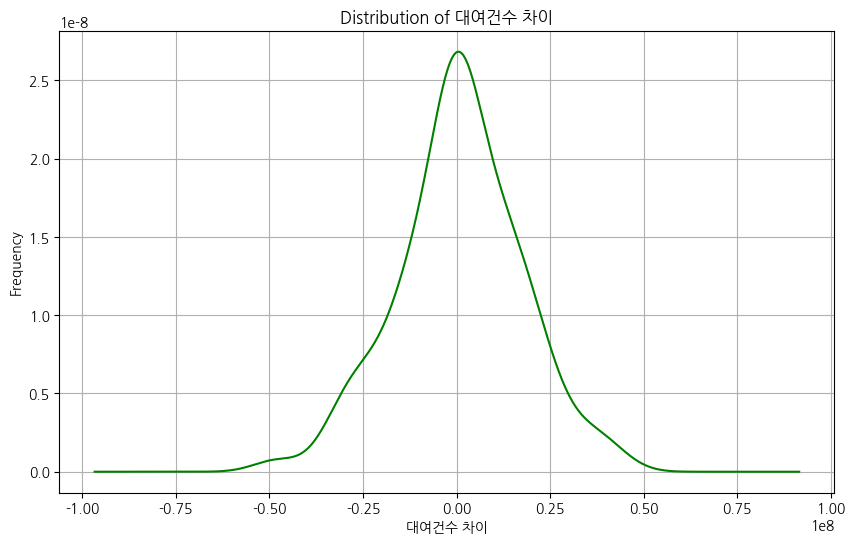

In [90]:
comparison_df = pd.merge(group_df_22, group_df_23, on=['month', 'day'], suffixes=('_22', '_23'))
comparison_df['대여건수_차이'] = comparison_df['대여건수_23'] - comparison_df['대여건수_22']

use_count_difference = comparison_df['대여건수_차이']

# Plot the histogram
plt.figure(figsize=(10, 6))
use_count_difference.plot(kind='kde', color='green')
plt.title('Distribution of 대여건수 차이')
plt.xlabel('대여건수 차이')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [91]:
comparison_df = pd.merge(group_df_22, group_df_23, on=['month', 'day'], suffixes=('_22', '_23'))
comparison_df['대여건수_차이'] = comparison_df['대여건수_23'] - comparison_df['대여건수_22']

In [92]:
group_7_8 = comparison_df[(comparison_df['month'] == 7) | (comparison_df['month'] == 8)]
group_9_10 = comparison_df[(comparison_df['month'] == 9) | (comparison_df['month'] == 10)]
group_11_12 = comparison_df[(comparison_df['month'] == 11) | (comparison_df['month'] == 12)]

In [93]:
#정규성 확인
shapiro_jul_aug = stats.shapiro(group_7_8['대여건수_차이'])
shapiro_sept_oct = stats.shapiro(group_9_10['대여건수_차이'])
shapiro_nov_dec = stats.shapiro(group_11_12['대여건수_차이'])
print(f'shapiro_jul_aug:{shapiro_jul_aug}')
print(f'shapiro_sept_oct:{shapiro_sept_oct}')
print(f'shapiro_nov_dec:{shapiro_nov_dec}')

shapiro_jul_aug:ShapiroResult(statistic=0.9846420890602211, pvalue=0.6304701481232631)
shapiro_sept_oct:ShapiroResult(statistic=0.9768512686758184, pvalue=0.3000327295439549)
shapiro_nov_dec:ShapiroResult(statistic=0.9535264941089006, pvalue=0.021281244077499057)


In [95]:
#Kruskal 방식 사용
kruskal_test_result = stats.kruskal(group_7_8['대여건수_차이'], group_9_10['대여건수_차이'], group_11_12['대여건수_차이'])
kruskal_test_result

KruskalResult(statistic=3.5321418295955027, pvalue=0.17100355815059343)

세 그룹 중 11~12월의 데이터가 정규성을 만족하지 않기 때문에 Kruskal방식 사용

p-value이 0.05를 넘기 떄문에 세 그룹간 유의미한 차이가 없다고 결론

### 3-3. 시계열 분해 : 추세, 계절성, 불규칙성으로 분해

- 추세 > 장기적인 흐름 (대여 건수가 시간이 지남에 따라 증가/감소 하는지) 
- 계절성 > 패턴 (특정 달에 대여 건수가 항상 더 많은지/적은지) 
- 불규칙성 > 일시적 변동이나 특정 이벤트 (잔차) 

In [343]:
rental_date = df_rental.groupby(pd.to_datetime(df_rental['대여일시'].dt.date.rename('date')))['자전거번호'].count().reset_index()

<Axes: >

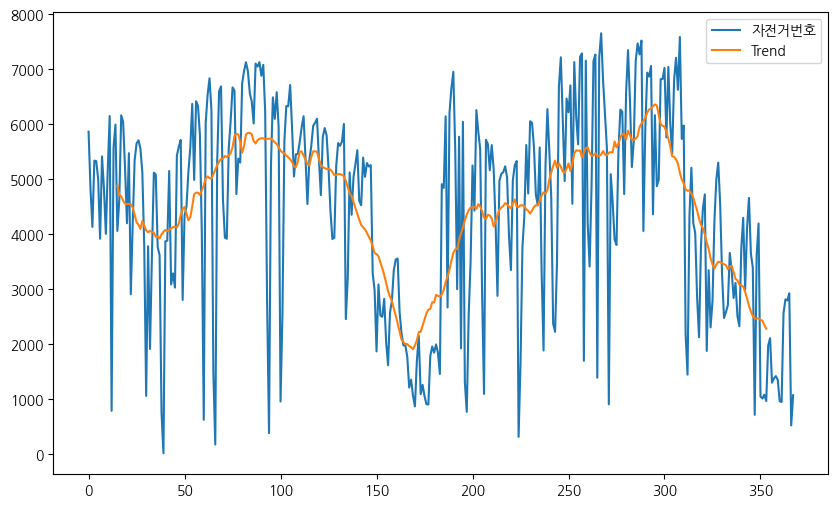

In [344]:
# 추세
rental_date['Trend'] = rental_date['자전거번호'].rolling(window=30, center=True).mean()
rental_date[['자전거번호', 'Trend']].plot(figsize=(10, 6))

<Axes: >

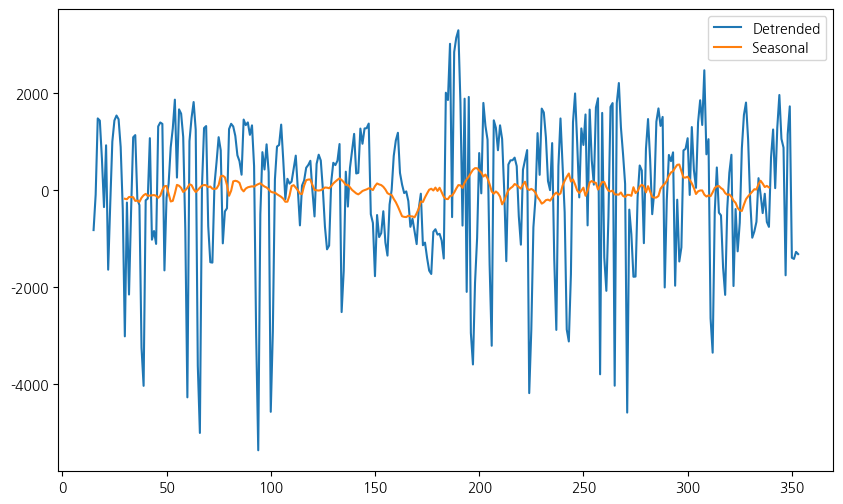

In [345]:
# 계절성을 구하기 위해 추세를 뺀 나머지 값 계산
rental_date['Detrended'] = rental_date['자전거번호'] - rental_date['Trend']

# 데이터에서 계절성을 구하기 (단순 평균을 사용)
# seasonal_period = 1 * 30  # 1개월
seasonal_period = 30
rental_date['Seasonal'] = rental_date['Detrended'].rolling(window=seasonal_period, center=True).mean()

# 계절성 시각화
rental_date[['Detrended', 'Seasonal']].plot(figsize=(10, 6))

<Axes: title={'center': 'Residual (잔차)'}>

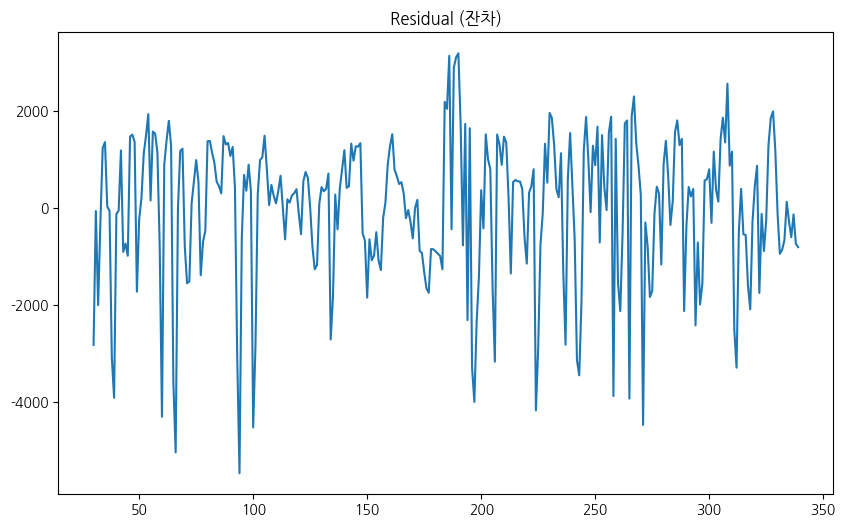

In [346]:
# 잔차 계산
rental_date['Residual'] = rental_date['자전거번호'] - rental_date['Trend'] - rental_date['Seasonal']

# 잔차 시각화
rental_date['Residual'].plot(figsize=(10, 6), title='Residual (잔차)')

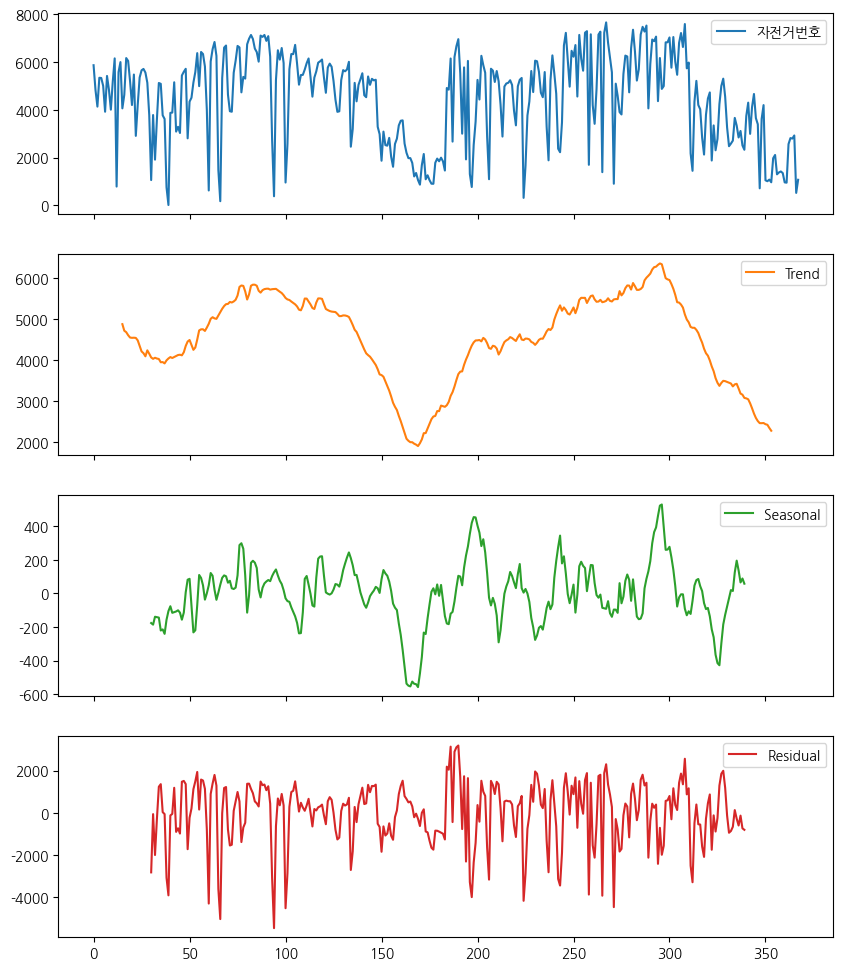

In [347]:
# 전체 성분을 시각화
rental_date[['자전거번호', 'Trend', 'Seasonal', 'Residual']].plot(subplots=True, figsize=(10, 12), layout=(4, 1))
plt.show()

추세 : 데이터의 변동이 많고, 특정 패턴이 명확히 보이지 않음
-> 초기 상승세를 보이다가 중간 지점에서 최고점을 도달한 후 하락세를 보이는 형태를 보임

계절성 : 일정한 주기에 따라 대여 건수의 증가와 감소를 반복하는 형태
진폭이 400-600대까지의 변동을 보이는 것으로 주기적으로 발생하는 계절적 요인이 자전거 대여 건수에 영향을 미친다고 할 수 있음

잔차 : 추세와 계절성으로 설명되지 않는 무작위적인 변동을 의미
잔차의 변동성이 큰 것으로 대여 건수에 설명되지 않을 요인이 많이 작용한 것을 의미

*현 실험 데이터와 무관하지만 코로나상황,대중요금인상,신규가입자 및 이용 이벤트 등이 될 수 있음